In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from IPython.display import display


##### Демонстрация бинарной классификации и трехмермерной регрессии работы GB
#
#    http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html
#    http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html
#
###########################################

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=42)

gbrt = GradientBoostingClassifier(random_state=42)
gbrt.fit(X_train, y_train)
print('Правильность на обучающем наборе: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gbrt.score(X_test, y_test)))

Правильность на обучающем наборе: 1.000
Правильность на тестовом наборе: 0.958


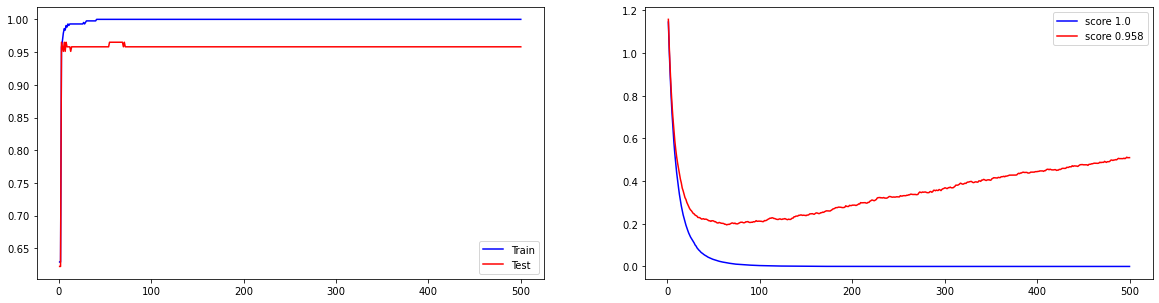

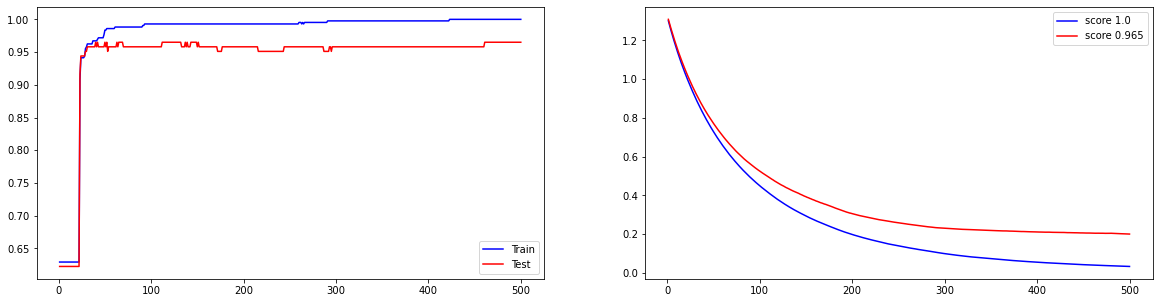

In [3]:
def plot_learnig_tree(estimator, X_train, X_test, y_train, y_test):  
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    n_estimators = estimator.n_estimators_
    zero = np.zeros(n_estimators, dtype=np.float64)
    color_one = 'blue'
    color_two = 'red'
    
    train_score = zero
    for i, y_pred_train in enumerate(estimator.staged_predict(X_train)):
        train_score[i] = accuracy_score(y_train, y_pred_train)
    ax1.plot(
        (np.arange(train_score.shape[0]) + 1),
        train_score,
        "-",
        color=color_one,
        label='Train',
        )
        
    test_score = zero
    for i, y_pred_test in enumerate(estimator.staged_predict(X_test)):
        train_score[i] = accuracy_score(y_test, y_pred_test)    
    ax1.plot(
        (np.arange(test_score.shape[0]) + 1),
        train_score,
        "-",
        color = color_two,
        label='Test',
        )
    ax1.legend(loc='best')


    train_deviance = zero
    for i, y_pred_train in enumerate(estimator.staged_decision_function(X_train)):
        train_deviance[i] = estimator.loss_(y_train, y_pred_train)
        
    ax2.plot(
        (np.arange(train_deviance.shape[0]) + 1),
        train_deviance,
        '-',
        color=color_one,
        label="score "+str(round(estimator.score(X_train, y_train),3))
    )

    test_deviance = zero
    for i, y_pred_test in enumerate(estimator.staged_decision_function(X_test)):
        test_deviance[i] = estimator.loss_(y_test, y_pred_test)
        
    ax2.plot(
        (np.arange(test_deviance.shape[0]) + 1),
        test_deviance,
        '-',
        color=color_two,
        label="score "+str(round(estimator.score(X_test, y_test),3))
    )
    ax2.legend(loc='best')
    
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=42)

clf = GradientBoostingClassifier(n_estimators=500,random_state=42)
clf.fit(X_train, y_train)
plot_learnig_tree(clf, X_train, X_test, y_train, y_test)

clf = GradientBoostingClassifier(n_estimators=500,random_state=42, learning_rate = 0.01)
clf.fit(X_train, y_train)
plot_learnig_tree(clf, X_train, X_test, y_train, y_test)

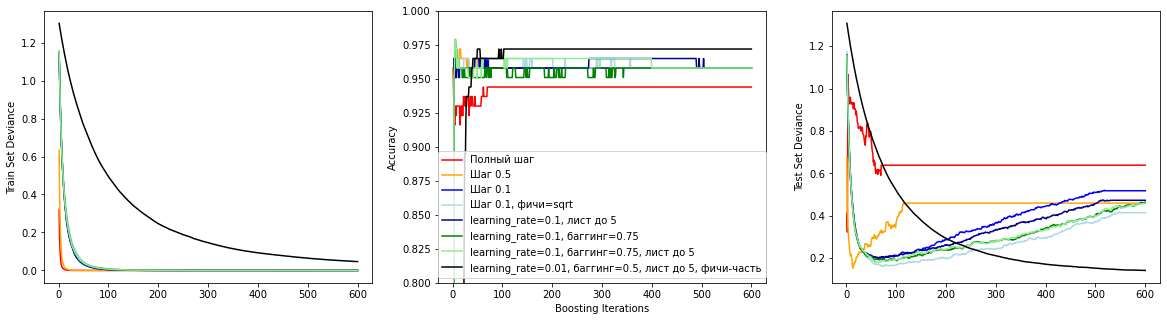

In [4]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=42)
labels, y = np.unique(cancer.target, return_inverse=True)


original_params = {
    "n_estimators": 600,
    #"max_leaf_nodes": None,
    #"max_depth": None,
    "random_state": 42,
    'criterion': 'friedman_mse'
    
}

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for label, color, setting in [
    ("Полный шаг", "red", {"learning_rate": 1.0, "subsample": 1.0}),
    ("Шаг 0.5", "orange", {"learning_rate": 0.5, "subsample": 1.0}),
    ("Шаг 0.1", "blue",   {"learning_rate": 0.1, "subsample": 1.0}),
    ("Шаг 0.1, фичи=sqrt",
              "lightblue", {"learning_rate": 0.1, "subsample": 1.0, "max_features": 'sqrt'},
    ),
    ("learning_rate=0.1, лист до 5",
               "darkblue", {"learning_rate": 0.1, "subsample": 1.0, "min_samples_split" : 5},
    ),
    ("learning_rate=0.1, баггинг=0.75",
                  "green", {"learning_rate": 0.1, "subsample": 0.75},
    ),
    ("learning_rate=0.1, баггинг=0.75, лист до 5",
             "lightgreen", {"learning_rate": 0.1, "subsample": 0.75, "min_samples_split" : 5},
    ),
    ("learning_rate=0.01, баггинг=0.5, лист до 5, фичи-часть",
             "black", {"learning_rate": 0.01, "subsample": 0.5, "min_samples_split" : 5, "max_features": 'sqrt'},
    ),
]:
    params = dict(original_params)
    params.update(setting)

    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    
    train_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_train)):
        train_deviance[i] = clf.loss_(y_train, y_pred)
        
    ax1.plot(
        (np.arange(train_deviance.shape[0]) + 1),
        train_deviance,
        "-",
        color=color,
        label=label,
    )

    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        #clf.loss_ assumes that y_test[i] in {0, 1}
        test_score[i] = accuracy_score(y_test, y_pred)
        
    ax2.plot(
        (np.arange(test_score.shape[0]) + 1),
        test_score,
        "-",
        color=color,
        label=label,
    )
    
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        #clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)
        

    ax3.plot(
        (np.arange(test_deviance.shape[0]) + 1),
        test_deviance,
        "-",
        color=color,
        label=label,
    )

ax2.legend(loc='lower center')
ax2.set_xlabel("Boosting Iterations")
ax2.set_ylim(0.8, 1.)
ax1.set_ylabel("Train Set Deviance")
ax2.set_ylabel("Accuracy")
ax3.set_ylabel("Test Set Deviance")

plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state= 10)

gbrt = GradientBoostingClassifier(learning_rate=0.1, subsample=0.75, min_samples_split=5, n_estimators=600,random_state=12)
gbrt.fit(X_train, y_train)
print('Правильность на обучающем наборе: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gbrt.score(X_test, y_test)))

Правильность на обучающем наборе: 1.000
Правильность на тестовом наборе: 0.972


In [6]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state= 10)

gbrt = GradientBoostingClassifier(learning_rate=0.01, subsample=0.5, min_samples_split=5, n_estimators=600,random_state=12)
gbrt.fit(X_train, y_train)
print('Правильность на обучающем наборе: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gbrt.score(X_test, y_test)))


Правильность на обучающем наборе: 1.000
Правильность на тестовом наборе: 0.986


In [7]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state= 10)

gbrt = GradientBoostingClassifier(learning_rate=0.1, subsample=0.75, min_samples_split=5, n_estimators=50,random_state=12)
gbrt.fit(X_train, y_train)
print('Правильность на обучающем наборе: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gbrt.score(X_test, y_test)))

Правильность на обучающем наборе: 0.998
Правильность на тестовом наборе: 0.965


In [8]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state= 10)

gbrt = GradientBoostingClassifier(learning_rate=0.01, subsample=0.5, min_samples_split=5, n_estimators=50,random_state=12)
gbrt.fit(X_train, y_train)
print('Правильность на обучающем наборе: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gbrt.score(X_test, y_test)))

Правильность на обучающем наборе: 0.967
Правильность на тестовом наборе: 0.944


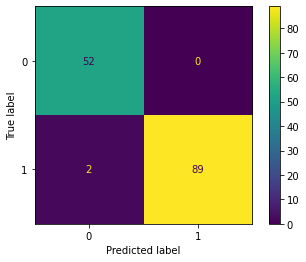

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state= 10)

gbrt = GradientBoostingClassifier(learning_rate=0.01, subsample=0.5, min_samples_split=5, n_estimators=600,random_state=12)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot();

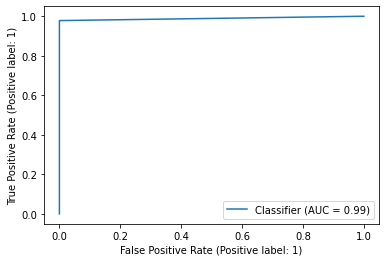

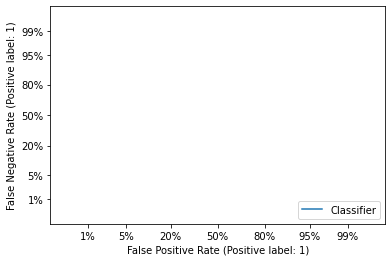

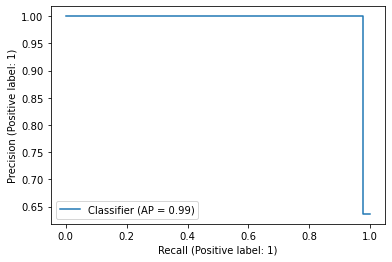

In [10]:
from sklearn.metrics import classification_report, RocCurveDisplay, DetCurveDisplay,PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_pred);
DetCurveDisplay.from_predictions(y_test, y_pred);
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.98      0.99        91

    accuracy                           0.99       143
   macro avg       0.98      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

